In [1]:
pip install torch torchvision torchaudio transformers datasets scikit-learn pandas numpy matplotlib seaborn tqdm gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-python-

# Data loading and processing

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_imdb_from_keras(num_words=20000, maxlen=256):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words)
    word_index = tf.keras.datasets.imdb.get_word_index()
    # convert back to text
    x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
    x_test  = pad_sequences(x_test,  maxlen=maxlen, padding='post', truncating='post')
    return (x_train, y_train), (x_test, y_test), word_index

In [2]:
(x_train_seq, y_train), (x_test_seq, y_test), word_index = load_imdb_from_keras()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# TF-IDF + Logistic Regression / SVM.

In [3]:
#Convert sequences back to text
index_word = {v+3: k for k, v in word_index.items()}
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

def sequences_to_texts(sequences):
    texts = []
    for seq in sequences:
        texts.append(" ".join([index_word.get(i, "?") for i in seq]))
    return texts

X_train = sequences_to_texts(x_train_seq)
X_test = sequences_to_texts(x_test_seq)

In [4]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.8)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
# Train models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
lr_preds = lr.predict(X_test_tfidf)  # <-- on prédit sur X_test_tfidf

lr_metrics = {
    'Accuracy': accuracy_score(y_test, lr_preds),
    'Precision': precision_score(y_test, lr_preds, average='weighted'),
    'Recall': recall_score(y_test, lr_preds, average='weighted'),
    'F1': f1_score(y_test, lr_preds, average='weighted')
}

# Linear SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
svm_preds = svm.predict(X_test_tfidf)

svm_metrics = {
    'Accuracy': accuracy_score(y_test, svm_preds),
    'Precision': precision_score(y_test, svm_preds, average='weighted'),
    'Recall': recall_score(y_test, svm_preds, average='weighted'),
    'F1': f1_score(y_test, svm_preds, average='weighted')
}



In [30]:
# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if len(set(y_test)) == 2:
        # ROC-AUC for binary classification
        if hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            y_score = model.predict_proba(X_test)[:, 1]
        print("ROC-AUC:", roc_auc_score(y_test, y_score))

print("Logistic Regression Evaluation:")
evaluate_model(lr, X_test_tfidf, y_test)
print("\nLinear SVM Evaluation:")
evaluate_model(svm, X_test_tfidf, y_test)

Logistic Regression Evaluation:
Accuracy: 0.86068
Precision: 0.8613028537471243
Recall: 0.86068
F1 Score: 0.8606199303120781
Confusion Matrix:
 [[10499  2001]
 [ 1482 11018]]
ROC-AUC: 0.9237799103999998

Linear SVM Evaluation:
Accuracy: 0.88332
Precision: 0.8835138088567113
Recall: 0.88332
F1 Score: 0.8833052570662453
Confusion Matrix:
 [[10901  1599]
 [ 1318 11182]]
ROC-AUC: 0.9400923456


#RNN with embeddings

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import f1_score
import numpy as np

In [10]:
# Prepare dataset

# Convert to torch tensors
X_train_tensor = torch.tensor(x_train_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test_seq, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size)


In [11]:
# Build RNN model
def build_rnn_model(vocab_size, embed_dim=128, hidden_dim=128, n_layers=1, bidirectional=True, dropout=0.3, pretrained_embeddings=None, freeze=False):
    if pretrained_embeddings is not None:
        embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze)
    else:
        embedding = nn.Embedding(vocab_size, embed_dim)

    rnn = nn.LSTM(
        input_size=embed_dim,
        hidden_size=hidden_dim,
        num_layers=n_layers,
        batch_first=True,
        bidirectional=bidirectional,
        dropout=dropout if n_layers > 1 else 0
    )

    direction = 2 if bidirectional else 1
    fc = nn.Linear(hidden_dim * direction, 1)

    return embedding, rnn, fc

# Instantiate model
vocab_size = 20000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding, rnn, fc = build_rnn_model(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, bidirectional=True)
embedding, rnn, fc = embedding.to(device), rnn.to(device), fc.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(list(embedding.parameters()) + list(rnn.parameters()) + list(fc.parameters()), lr=1e-3)

In [12]:
# Forward function
def forward(x):
    emb = embedding(x)
    output, (h_n, c_n) = rnn(emb)

    if rnn.bidirectional:
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
    else:
        h_n = h_n[-1]

    logits = fc(h_n)
    return logits.squeeze()

In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialiser les listes pour les deux modèles
metrics_vanilla = []
metrics_attention = []

In [28]:
# Move model to GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding, rnn, fc = embedding.to(device), rnn.to(device), fc.to(device)

# Training loop with early stopping
num_epochs = 10
patience = 2
best_f1 = 0
trigger_times = 0

for epoch in range(num_epochs):

    rnn.train()
    embedding.train()
    fc.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = forward(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

     # --- Evaluation ---
    rnn.eval()
    embedding.eval()
    fc.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = forward(xb)
            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())

    # Convert probabilities to binary 0/1
    all_preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds_bin)
    prec = precision_score(all_labels, all_preds_bin)
    rec = recall_score(all_labels, all_preds_bin)
    f1 = f1_score(all_labels, all_preds_bin)
    metrics_vanilla.append({'Epoch': epoch+1, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})



    print(f"Epoch {epoch+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        trigger_times = 0
        torch.save({'embedding': embedding.state_dict(),
                    'rnn': rnn.state_dict(),
                    'fc': fc.state_dict()}, "best_rnn_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

print(f"Best F1: {best_f1:.4f}")

Epoch 1 | Acc: 0.8470 | Prec: 0.8551 | Recall: 0.8356 | F1: 0.8452
Epoch 2 | Acc: 0.8470 | Prec: 0.8512 | Recall: 0.8410 | F1: 0.8461
Epoch 3 | Acc: 0.8460 | Prec: 0.8532 | Recall: 0.8358 | F1: 0.8444
Epoch 4 | Acc: 0.8437 | Prec: 0.8710 | Recall: 0.8070 | F1: 0.8378
Early stopping!
Best F1: 0.8461


# Bahdanau Attention

Epoch 1 | Acc: 0.8514 | Prec: 0.8529 | Recall: 0.8491 | F1: 0.8510
Epoch 2 | Acc: 0.8510 | Prec: 0.8660 | Recall: 0.8306 | F1: 0.8479
Epoch 3 | Acc: 0.8525 | Prec: 0.8602 | Recall: 0.8418 | F1: 0.8509
Early stopping!
Best F1 with Attention: 0.8510

=== Top 100 mots par poids d'attention ===

  1. give             ->  0.0187
  2. flat             ->  0.0175
  3. a                ->  0.0175
  4. flat             ->  0.0173
  5. flat             ->  0.0172
  6. all              ->  0.0170
  7. work             ->  0.0168
  8. kristy           ->  0.0167
  9. swanson          ->  0.0165
 10. this             ->  0.0164
 11. a                ->  0.0164
 12. one              ->  0.0164
 13. on               ->  0.0163
 14. give             ->  0.0162
 15. this             ->  0.0162
 16. miss             ->  0.0162
 17. allowed          ->  0.0159
 18. please           ->  0.0158
 19. is               ->  0.0158
 20. to               ->  0.0156
 21. miss             ->  0.0156
 22. fans     

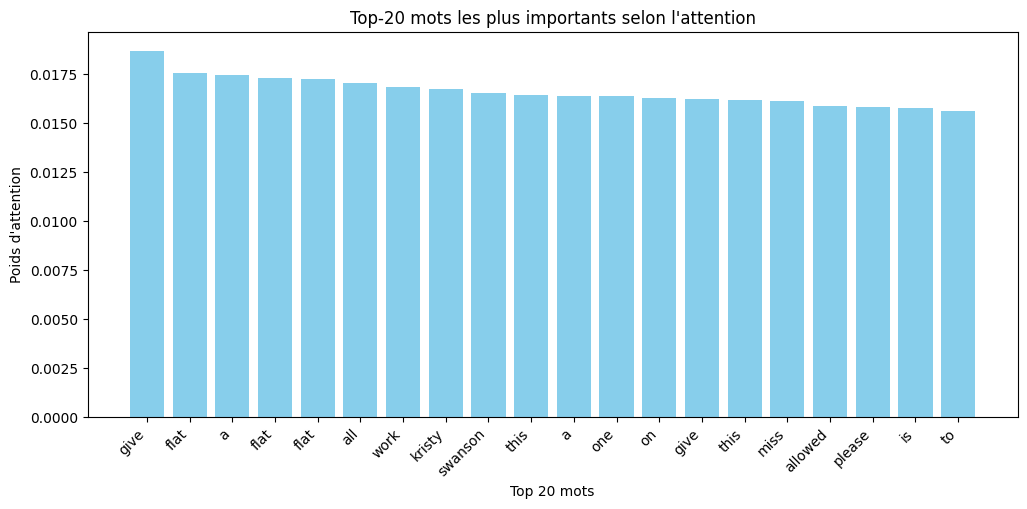

/tmp/ipython-input-4016707192.py:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import HTML

# Bahdanau Attention
def bahdanau_attention(rnn_outputs, hidden, mask=None):
    """
    rnn_outputs: (batch, seq_len, hidden*direction)
    hidden: (batch, hidden*direction)
    mask: (batch, seq_len) with 1 for valid tokens, 0 for padding
    """
    W1 = nn.Linear(rnn_outputs.size(2), rnn_outputs.size(2)).to(rnn_outputs.device)
    W2 = nn.Linear(hidden.size(1), rnn_outputs.size(2)).to(rnn_outputs.device)
    V  = nn.Linear(rnn_outputs.size(2), 1).to(rnn_outputs.device)

    hidden_expanded = hidden.unsqueeze(1)
    score = V(torch.tanh(W1(rnn_outputs) + W2(hidden_expanded))).squeeze(-1)  # (batch, seq_len)

    if mask is not None:
        score = score.masked_fill(mask == 0, float('-inf'))  # mask padding

    attn_weights = F.softmax(score, dim=1)  # (batch, seq_len)
    context = torch.sum(attn_weights.unsqueeze(-1) * rnn_outputs, dim=1)
    return context, attn_weights

#Mask for <PAD>
def create_padding_mask(x, pad_idx=0):
    # x: (batch, seq_len)
    mask = (x != pad_idx).float()  # 1 for real tokens, 0 for <PAD>
    return mask


# Forward avec attention
def forward_with_attention(x):
    emb = embedding(x)
    rnn_outputs, (h_n, c_n) = rnn(emb)

    if rnn.bidirectional:
        h_n_last = torch.cat((h_n[-2], h_n[-1]), dim=1)
    else:
        h_n_last = h_n[-1]

    mask = create_padding_mask(x)  # new mask
    context, attn_weights = bahdanau_attention(rnn_outputs, h_n_last, mask=mask)
    logits = fc(context)
    return logits.squeeze(), attn_weights

# Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(list(embedding.parameters()) + list(rnn.parameters()) + list(fc.parameters()), lr=1e-3)

# Training loop with early stopping
num_epochs = 10
patience = 2
best_f1 = 0
trigger_times = 0
metrics_attention = []

for epoch in range(num_epochs):
    embedding.train()
    rnn.train()
    fc.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits, _ = forward_with_attention(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    # Evaluation
    embedding.eval()
    rnn.eval()
    fc.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = forward_with_attention(xb)
            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())

    all_preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, all_preds_bin)
    prec = precision_score(all_labels, all_preds_bin)
    rec = recall_score(all_labels, all_preds_bin)
    f1 = f1_score(all_labels, all_preds_bin)

    print(f"Epoch {epoch+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    metrics_attention.append({'Epoch': epoch+1, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        trigger_times = 0
        torch.save({'embedding': embedding.state_dict(),
                    'rnn': rnn.state_dict(),
                    'fc': fc.state_dict()}, "best_rnn_attention.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

print(f"Best F1 with Attention: {best_f1:.4f}")

# =============================
# Interprétation des poids d’attention (Top-100 mots + viz)
# =============================

# Exemple sur le premier batch
xb, yb = next(iter(test_loader))
xb, yb = xb.to(device), yb.to(device)
_, attn_weights = forward_with_attention(xb)

# attn_weights: (batch, seq_len, 1)
attn_weights = attn_weights.squeeze(-1).cpu().detach().numpy()

# Premier exemple
tokens = xb[0].cpu().numpy()
weights = attn_weights[0]

# Convertir indices -> mots
words = [index_word.get(idx, "<UNK>") for idx in tokens]

# Trier les tokens par poids d'attention (descendant)
sorted_indices = weights.argsort()[::-1]

# Top-k
topk = 100
top_indices = sorted_indices[:topk]
top_words = [words[i] for i in top_indices]
top_weights = [weights[i] for i in top_indices]

# === Liste imprimée des top-100 mots ===
print("\n=== Top 100 mots par poids d'attention ===\n")
for rank, (w, wt) in enumerate(zip(top_words, top_weights), 1):
    print(f"{rank:3d}. {w:15s}  ->  {wt:.4f}")

# === Visualisation 1 : barplot avec top-20 pour lisibilité ===
plt.figure(figsize=(12,5))
plt.bar(range(20), top_weights[:20], color="skyblue")
plt.xticks(range(20), top_words[:20], rotation=45, ha="right")
plt.xlabel("Top 20 mots")
plt.ylabel("Poids d'attention")
plt.title("Top-20 mots les plus importants selon l'attention")
plt.show()

# === Visualisation 2 : texte colorié (top-20 pour ne pas saturer) ===
def highlight_attention(words, weights):
    cmap = cm.get_cmap('Reds')
    highlighted = []
    for w, alpha in zip(words, weights):
        color = cm.colors.rgb2hex(cmap(alpha / max(weights)))  # normaliser
        highlighted.append(f"<span style='background-color:{color}'>{w}</span>")
    return " ".join(highlighted)

HTML(highlight_attention(top_words[:20], top_weights[:20]))



# Comparaison

In [31]:
df_vanilla = pd.DataFrame(metrics_vanilla)
df_attention = pd.DataFrame(metrics_attention)

In [35]:
import pandas as pd

# Meilleures performances selon F1
best_vanilla = df_vanilla.loc[df_vanilla['F1'].idxmax()]
best_attention = df_attention.loc[df_attention['F1'].idxmax()]

# Transformer les dict en Series
lr_series = pd.Series(lr_metrics)
svm_series = pd.Series(svm_metrics)

# Créer le tableau comparatif
comparison_table = pd.DataFrame([
    best_vanilla[['Accuracy', 'Precision', 'Recall', 'F1']],
    best_attention[['Accuracy', 'Precision', 'Recall', 'F1']],
    lr_series,
    svm_series
], index=['Vanilla RNN', 'RNN + Attention', 'TF-IDF + LR', 'TF-IDF + SVM'])

# --- Style du tableau ---
styled_table = (comparison_table.style
                .bar(subset=['Accuracy', 'Precision', 'Recall', 'F1'], color='#5fba7d')
                .highlight_max(color='#ffa07a', axis=0)
                .set_caption("Comparaison des performances : RNN, Attention et TF-IDF")
                .set_properties(**{'text-align': 'center'})
                .format("{:.3f}")
               )

styled_table




,Accuracy,Precision,Recall,F1
Vanilla RNN,0.859,0.877,0.836,0.856
RNN + Attention,0.851,0.853,0.849,0.851
TF-IDF + LR,0.861,0.861,0.861,0.861
TF-IDF + SVM,0.883,0.884,0.883,0.883


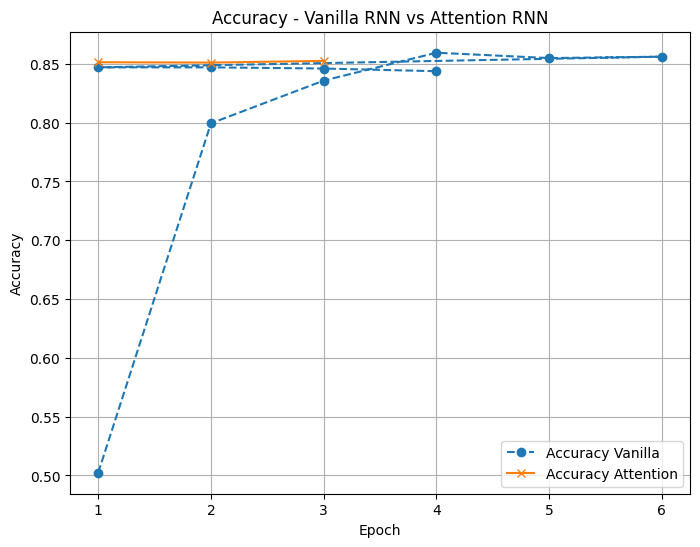

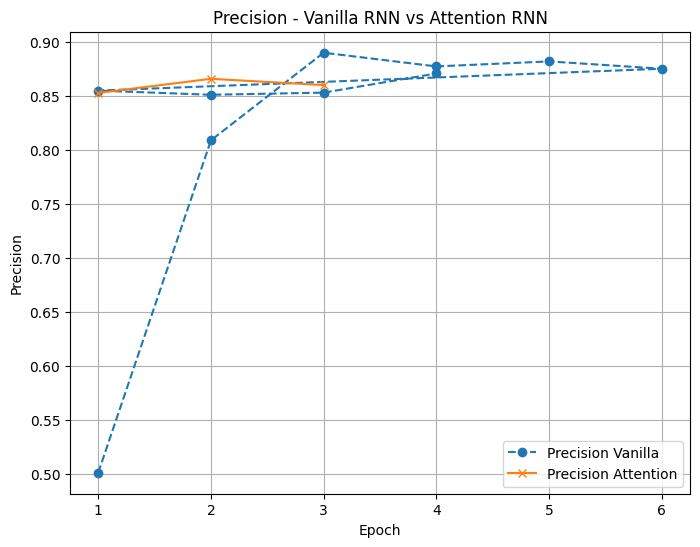

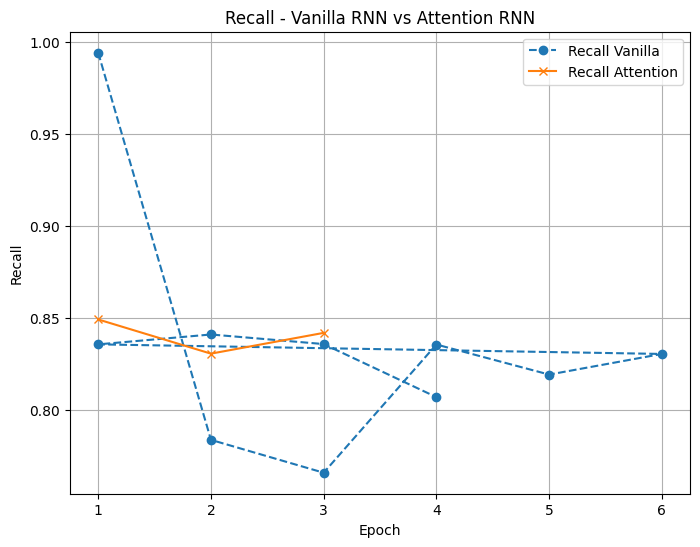

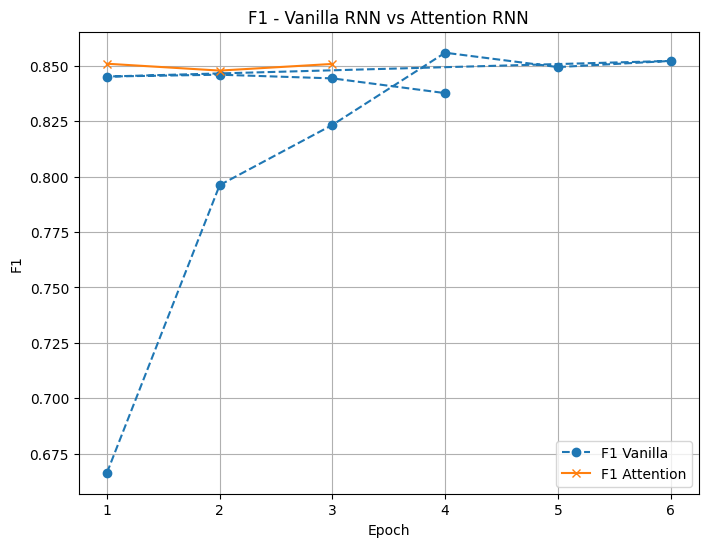

In [36]:

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for metric in metrics:
    plt.figure(figsize=(8,6))
    plt.plot(df_vanilla['Epoch'], df_vanilla[metric], label=f"{metric} Vanilla", linestyle='--', marker='o')
    plt.plot(df_attention['Epoch'], df_attention[metric], label=f"{metric} Attention", linestyle='-', marker='x')
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{metric} - Vanilla RNN vs Attention RNN")
    plt.legend()
    plt.grid(True)
    plt.show()
